In [3]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Figure 6j,k

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os.path as path
import os

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from scipy.signal import hilbert

from submanifolds.utils import get_root
from submanifolds.ringnet.network import RingNetworkVariableSpeed
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import get_root


#### Color palettes

In [3]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

In [4]:
root = get_root()
save_figs_flag = 0

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_6/'

# Data storage
data_top_dir = root + 'data/'
data_dir = data_top_dir + 'simulaneous_control/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('fig dir exists')

if not os.path.isdir(data_top_dir):
    os.mkdir(data_top_dir)
    print('Created ' + data_top_dir)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    print('Created ' + data_dir)
else:
    print('data dir exists')

fig dir exists
data dir exists


In [5]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [6]:
sigma = 0.04
shift = 0.04
_w_E = 5
N = 1000
T = 2001 
tau = 100 

n_seeds = 5
seeds = np.arange(n_seeds)

# speed control
speeds = [1, 2, 5, 10] #np.arange(1,17,3).round(2) #np.arange(1,500,4).round(2) #([2.36] * np.arange(0.5,10,0.25)).round(2)
n_speeds = len(speeds)

# shape control
shapes = np.array([-1.25, -0.625, 0, 0.625, 1.25]) #np.arange(-1.25,1.75,.5) #np.arange(-1.25,1.5,.25) #np.arange(-2.5,3,0.25) #np.arange(-1.5,2.5,0.5) #np.arange(-1,2.5,0.5)
n_shapes = len(shapes)
t_shape_input = 125
sd_shape_input = 12 #25
baseline_traj = np.where(shapes==0)[0][0]

# subspaces
perc_sel = np.arange(0,1,0.1).round(2) #np.arange(0).round(2)
n_perc_sel = len(perc_sel)

# shape 2 -- activation function maxima
r_max_vals = [0] #[-0.5,-0.3,0,0.5,1]
n_r_max_vals = len(r_max_vals)
r_max = np.ones((T,N))

active_neurons = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
average_rate = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,T))
raster = np.zeros((n_perc_sel,n_speeds,n_shapes,n_seeds,N,T))

In [7]:
n_speeds * n_shapes * n_perc_sel * n_r_max_vals * n_seeds

1000

In [8]:
speeds

[1, 2, 5, 10]

## Functions

In [9]:
def center_raster(raster, normalize=True):
    # center the data
    R_centered = raster - raster.mean(axis=1, keepdims=True)
    if normalize:
        std = raster.std(axis=1, keepdims=True)
        R_centered = np.divide(R_centered, std, where=std!=0)
    return R_centered

In [10]:
def compute_pca(raster, n_components=2, normalize=True, compute_trajectory=False):

    # center and normalize, returns 
    centered_raster = center_raster(raster, normalize)
        
    # compute PCA
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(centered_raster.T)

    if compute_trajectory:
        # project onto PCs
        trajectory = project_onto_basis(centered_raster, pca.components_)
    else:
        trajectory = None
    
    return pca, trajectory, centered_raster

In [11]:
def project_onto_basis(raster, basis):
    return basis @ raster

In [12]:
def compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    diff = np.sqrt(np.sum((trajectory_1 - trajectory_2)**2, axis=0))
    peak_loc = t0 + np.argmax(diff[input_range])
    sign_diff = np.sign(np.sqrt(np.sum(trajectory_1[:,peak_loc]**2)) - np.sqrt(np.sum(trajectory_2[:,peak_loc]**2)))
    max_diff = sign_diff * diff[peak_loc] / np.sqrt(np.sum(trajectory_2[:,peak_loc]**2))

    return max_diff

In [13]:
def compute_trajectory_perturbation_from_raster(raster_1, raster_2, basis, t_center=t_shape_input, t_half_width=2*sd_shape_input):

    tol = .00001
    if (np.abs(raster_1.mean(axis=1)) > tol).any() or (np.abs(raster_2.mean(axis=1)) > tol).any():
        print("NOT CENTERED!")

    trajectory_1 = project_onto_basis(raster_1, basis)
    trajectory_2 = project_onto_basis(raster_2, basis)

    max_diff = compute_trajectory_perturbation(trajectory_1, trajectory_2, t_center, t_half_width)

    return max_diff

In [14]:
def compute_trajectory_rotational_speed(raster, basis):
    trajectory = project_onto_basis(raster, basis)
    analytic_signal = hilbert(trajectory)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    initial_phase = np.min(instantaneous_phase, axis=1, keepdims=True)
    instantaneous_phase = instantaneous_phase - initial_phase
    n_rotations = np.mean(np.max(instantaneous_phase, axis=1, keepdims=True)/(2*np.pi))
    return n_rotations

In [15]:
def compute_bump_speed(raster, thr_act = 0, thr_sep = 500):
    N = np.shape(raster)[0]
    T = np.shape(raster)[1]
    bump_center = np.zeros(T)
    pos_cumulative = np.zeros(T)
    for t in range(T):
        neurons_above_thr = np.where(raster[:,t] > thr_act)[0]
        if (np.max(neurons_above_thr) - np.min(neurons_above_thr)) > thr_sep:
            neurons_above_thr[neurons_above_thr<thr_sep] += N
        bump_center[t] = np.mean(neurons_above_thr) % N

    bump_speed = (bump_center[1:] - bump_center[:-1]) % N

    pos_cumulative[0] = bump_center[0]
    for k in range(1,T):
        pos_cumulative[k] = bump_center[0] + np.sum(bump_speed[:k])
    return bump_center, bump_speed, pos_cumulative

In [16]:
def compute_maximum_relative_bump_width(active_neurons, active_neurons_ref, t_center=t_shape_input, t_half_width=2*sd_shape_input):
    t0 = int(t_center - t_half_width)
    t1 = int(t_center + t_half_width)
    input_range = np.arange(t0,t1)
    
    bump_width = (active_neurons[input_range] - active_neurons_ref[input_range]) / active_neurons_ref[input_range]
    max_loc = np.argmax(np.abs(bump_width))
    max_rel_width = bump_width[max_loc]
    return max_rel_width

In [17]:
def compute_subspace_angle(basis_1, basis_2):
    u, s, vh = np.linalg.svd(np.dot(basis_1, basis_2.T), full_matrices=True)
    angles = np.arccos(np.clip(s, -1, 1))*180/np.pi
    return angles.mean()

In [18]:
def compute_subspace_angle_from_raster(raster_1, raster_2):
    pca_1 = compute_pca(raster_1)[0]
    pca_2 = compute_pca(raster_2)[0]
    basis_1 = pca_1.components_
    basis_2 = pca_2.components_
    angle = compute_subspace_angle(basis_1, basis_2)
    return angle

In [19]:
class Status:
    def __init__(self, total_iterations):
        self.total_iterations = total_iterations
        self.current_iteration = 0

    def it(self):
        self.current_iteration +=1
        print('\r: ' + str(self.current_iteration) + '/' + str(self.total_iterations), end='')

In [20]:
def compile_aggregate_raster(rasters):
    shape = np.shape(rasters)
    N = np.shape(rasters)[-2]
    T = np.shape(rasters)[-1]
    
    #n_speeds = np.shape(rasters)[2]
    #n_shapes = np.shape(rasters)[3]
    
    joint_raster = np.zeros((N,1))
    for speed_i in range(n_speeds):
        for shape_i in range(n_shapes):
            joint_raster = np.concatenate([joint_raster, rasters[:,:,speed_i,shape_i]], axis=1)
        
    joint_raster = joint_raster[:,1:]
    return joint_raster

## Run simulations

In [21]:
for p_i, p in enumerate(perc_sel):
    for k, seed in enumerate(seeds):
        params_to_update = {'keys':     ['N','sigma_percent', 'shift_percent', 'T', '_w_E', 'p_inh', 'seed', 'stim', 'type'], 
                            'setting':  [N, sigma, shift, T, _w_E, p, seed, 'transient', 'projection']}

        params = Parameters(params_to_update)

        # generate initial condition
        S = speeds[0]*np.ones(T)
        net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
        initial_t = 250
        center = 0
        x = net.params.x
        width = int(net.params.sigma)
        max_active = net.params.P * r_max[0]
        initial_r = max_active * np.exp(-0.5 * (x - center)**2 / (width)**2)
        params.initial_r = initial_r
        net.run()
        initial_r = net.R[:,initial_t]
        params.initial_r = initial_r

        for j, A in enumerate(shapes):
            I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input)

            for i, I_E in enumerate(speeds):
                #I_ext = gaussian(np.arange(T), A, t_shape_input, sd_shape_input[i])
                S = I_E*np.ones(T)
                net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max, I_ext=I_ext) 
                net.run()
                active_neurons[p_i,i,j,k,:] = np.sum(net.R > 0, axis=0)
                average_rate[p_i,i,j,k,:] = np.mean(net.R, axis=0)
                raster[p_i,i,j,k,:,:] = net.R
    print(p)

/home/andrew/Documents/projects/submanifolds/submission_dynamic_control/code/submanifolds/ringnet/parameters.py:66: UserWarning: Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.
  warnings.warn('Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.')


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [22]:
plot = Plot()

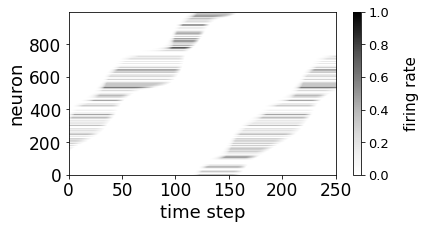

In [26]:
perc = -2
speed = -1
traj = 0
seed = 4
point = (perc, speed, traj, seed)
plot.activity_raster(raster[point][:,:251])

## Effect of speed and shape on rotation

In [27]:
total_iterations = n_perc_sel * n_speeds * n_shapes * n_seeds
status = Status(total_iterations)
K = 2
size = (n_perc_sel, n_speeds, n_shapes, n_seeds, K, N)
basis = np.zeros(size)

for p_i, p in enumerate(perc_sel):
    for subspace_i, subspace in enumerate(seeds):        
        for speed_i, speed in enumerate(speeds):
            for shape_i, shape in enumerate(shapes):
                point = (p_i, speed_i, shape_i, subspace_i)
                basis[point] = compute_pca(raster[point], n_components=K)[0].components_
                status.it()

: 1000/1000

In [28]:
size = (n_perc_sel, n_speeds, n_shapes, int(n_seeds*(n_seeds-1)/2))
angles = np.zeros(size)
for p_i, p in enumerate(perc_sel):    
    for speed_i, speed in enumerate(speeds):
        for shape_i, shape in enumerate(shapes):
            count = 0
            for subspace_i in range(n_seeds):
                pt_1 = (p_i, speed_i, shape_i, subspace_i)
                for subspace_j in range(subspace_i+1, n_seeds):
                    pt_2 = (p_i, speed_i, shape_i, subspace_j)
                    angles[pt_1[:-1]][count] = compute_subspace_angle(basis[pt_1], basis[pt_2])
                    count += 1

/tmp/ipykernel_4200/1567809555.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(0,90,10), fontsize=13)


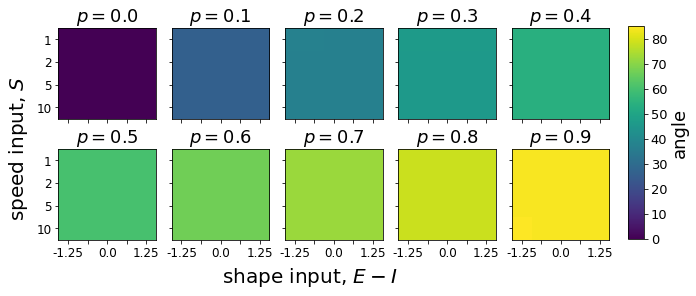

In [29]:
fname='angle_rasters_for_different_speeds_and_shapes'
fig, axes = plt.subplots(2, 5, figsize=(8.5,4), sharex=True, sharey=True, layout='constrained')

for p_i, ax in enumerate(axes.flat):
    mean_angles = angles[p_i,:,:,:].mean(axis=2)
    im = ax.imshow(mean_angles, vmin=0,vmax=85, aspect='auto')
    ax.set_xticks(np.arange(n_shapes), shapes, fontsize=12) # rotation=45)
    ax.set_yticks(np.arange(n_speeds), speeds, fontsize=12)
    for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    ax.set_title('$p=$'+ str(perc_sel[p_i].round(2)), fontsize=18)
    
cax = fig.add_axes([ax.get_position().x1+0.12,
                    ax.get_position().y0+.06,
                    0.025,
                    2.15*ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='angle',size=18)
cbar.set_ticklabels(np.arange(0,90,10), fontsize=13)

fig.supxlabel('shape input, $E-I$', fontsize=20)
fig.supylabel('speed input, $S$', fontsize=20)

if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()

In [30]:
colors_viridis = plt.cm.viridis(np.linspace(0,1,n_perc_sel))

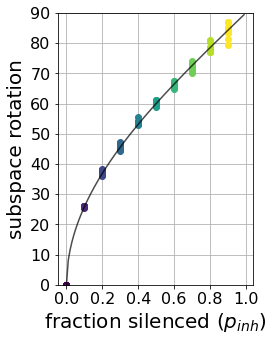

In [31]:
fname='angle_vs_perc_inh_curve'
fig, ax = plt.subplots(figsize=(3.5,5))

speed_i = 0
traj_i = baseline_traj

for i in range(n_perc_sel):
    plt.scatter(perc_sel[i]*np.ones(int(n_seeds*(n_seeds-1)/2)), angles[i,speed_i,traj_i,:], color=colors_viridis[i])

p_x = np.arange(0,1,0.01)
plt.plot(p_x, (180/np.pi)*np.arccos(1-p_x), color='black', alpha=0.7)
plt.xlabel('fraction silenced ($p_{inh}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('subspace rotation', fontsize=20)
plt.yticks(fontsize=16)
plt.ylim(0,90)
plt.grid('on')
ax.set_axisbelow(True)
if save_figs_flag:
    plt.savefig(fig_dir+fname + '.png', dpi=200, bbox_inches="tight")
    plt.savefig(fig_dir+fname + '.pdf', bbox_inches="tight")
plt.show()